# Implementation Details
Using NMF topic modeling, we examined the abstracts of 42 publications for common topics related to microservices-based applications and container security. 

# Step 1 - Implement class to extract data from the PDF files

In [1]:
import PyPDF2
import sys
import os
import re
from os.path import isfile, join
import pandas as pd
from datetime import datetime

# Hide the unwanted warnings
import warnings
warnings.filterwarnings('ignore')

class MyExtractor:
    replaceTerms = {}
    abstracts = []
    documentsDF = pd.DataFrame()
    counter = 0
    
    abstractStoppers = ['index terms',
                        'the authors',
                        'ccs concepts',
                        'introduction',
                        'keywords']
    abstractStarters = ['abstract',
                        'a b s t r a c t']
    
    # A method add record in the documentsDF dataframe
    # The dataset documentsDF will have columns,
    # Title, PublishDate & Cleaned Abstract
    def addDocument(self, title, docText, publishDate):
        self.documentsDF.loc[self.counter, 'Title'] = title
        self.documentsDF.loc[self.counter, 'PublishDate'] = publishDate
        self.documentsDF.loc[self.counter, 'Abstract'] = docText
        self.counter = self.counter + 1

    # A method to extract 'abstract' from the PDF files
    # It also extracts metadata of the PDF File,
    # such as title and publication year
    def convertToTextPyPDF2(self, pdfFile, writeToFile):
        abstractEnd = False
        abstractFound = False
        with open(pdfFile, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            num_pages = len(pdf_reader.pages)
            paperMetadata = pdf_reader.metadata

            abstract = ""
            words = ""

            for i in range(num_pages):
                page = pdf_reader.pages[i]
                text = page.extract_text()
                text = self.cleanText(text)

                last = ""
                for w in text.split():
                    w = w.replace('.','').replace(',','').replace(' ', '')
                    w = re.sub('[^a-zA-Z]', '', w).lower()
                    w = w.strip()
                    if len(w) == 0:
                        continue

                    if not abstractFound:
                        for starter in self.abstractStarters:
                            if w.startswith(starter) or words.endswith(starter):
                                abstractFound = True
                                break
                        if not abstractFound:
                            words = words + w
                    else:
                        abstract = abstract + ' ' + w
                        for endword in self.replaceTerms.keys():
                            if abstract.endswith(endword):
                                abstract = abstract.replace(endword, self.replaceTerms[endword])
                        for stopper in self.abstractStoppers:
                            if abstract.endswith(stopper):
                                abstract = abstract.replace(stopper, '')
                                abstractEnd = True
                                break
                    
                    if abstractEnd:
                        break
                
                if abstractEnd:
                    break
                    
        docTitle = ''
        docDate = ''
                    
        if '/Title' in paperMetadata:
            docTitle = paperMetadata['/Title']
    
        try:
            dt = datetime.strptime(paperMetadata['/CreationDate'].replace("'", ""), "D:%Y%m%d%H%M%S%z")
            docDate = str(dt.year)
        except:
            docDate = ''
        
        if abstractEnd and writeToFile:
            file = open(pdfFile.replace('.pdf','.txt'), 'w')
            file.write(abstract)
            file.close

        return abstract, docTitle, docDate

    def extractAbstractsUsingPyPDF2(self, writeToFile, delTextFile):
        self.replaceTerms['t erms'] = 'terms'
        self.replaceTerms['t ermsmicroservice'] = 'terms'
        self.replaceTerms['i i ntroduction'] = 'introduction'
        self.replaceTerms['microservicebased'] = 'microservice based'
        self.replaceTerms['automationheavy'] = 'automation heavy'
        self.replaceTerms['moni-toring'] = 'monitoring'

        if len(sys.argv) == 2:
            self.abstracts.append(self.convertToTextPyPDF2(sys.argv[1], writeToFile))
        else:
            files = [f for f in os.listdir('.') if os.path.isfile(f)]
            for f in files:
                if f.endswith(".pdf"):
                    if delTextFile:
                        txtFile = f.replace('.pdf', '.txt')
                        if os.path.exists(txtFile):
                            os.remove(txtFile)
                            print(txtFile, ' deleted!')

                    print("Extracting abstract from " + f)
                    abstract, docTitle, docDate = self.convertToTextPyPDF2(f, writeToFile)
                    self.addDocument(docTitle, abstract, docDate)
                    self.abstracts.append(abstract)
        return self.abstracts, self.documentsDF


    # A method to clean the extracted abstracts
    def cleanText(self, text):
        # removing paragraph numbers
        text = re.sub('[0-9]+.\t','',str(text))

        # removing new line characters
        text = re.sub('\n ','',str(text))
        text = re.sub('\n',' ',str(text))

        # removing apostrophes
        text = re.sub("'s",'',str(text))
        text = re.sub("’s",'',str(text))

        # removing hyphens
        text = re.sub("— ",'',str(text))
        text = re.sub("—",'',str(text))

        # removing quotation marks
        text = re.sub('\"','',str(text))
        text = re.sub('\”','',str(text))

        # removing any reference to outside text
        text = re.sub("[\(\[].*?[\)\]]", "", str(text))

        text = re.sub('ﬁ','fi',str(text))
        text = re.sub('JSON Web Token -based','JWT based',str(text))
        text = re.sub('micros- ervices-based','microservices based',str(text))
        text = re.sub('deploy - ment','deployment',str(text))
        text = re.sub('dif- ferent','different',str(text))
        text = re.sub('transpar - ently','trasparently',str(text))
        text = re.sub('commu- nication','communication',str(text))
        text = re.sub('detec- tion','detection',str(text))
        text = re.sub('Long Short-Term Memory','LSTM',str(text))
        text = re.sub('web securit','web security',str(text))
        text = re.sub('feder- ation','federation',str(text))
        text = re.sub('differ- ent','different',str(text))
        text = re.sub('Cloud-native','cloud native',str(text))
        text = re.sub('container- level','container level',str(text))
        text = re.sub('KeywordsDocker','Keywords Docker',str(text))
        text = re.sub('SP  800-190','SP',str(text))
        text = re.sub('of 2020','',str(text))
        text = re.sub('cus- tomer','customer',str(text))
        text = re.sub('run-time','runtime',str(text))
        text = re.sub('98.3% test accuracy','better test accuracy',str(text))
        text = re.sub('with a false negative rate of 1.6%','',str(text))
        text = re.sub('– a','a',str(text))
        text = re.sub('container-','container',str(text))
        text = re.sub('applica- tion','application',str(text))
        text = re.sub('T erms','Terms',str(text))
        text = re.sub('containerisa- tion','containerization',str(text))
        text = re.sub('lightw eight','light weight',str(text))
        text = re.sub('micros ervice','microservice',str(text))
        text = re.sub('ﬂ','fl',str(text))
        text = re.sub('dis  tributed','distributed',str(text))
        text = re.sub('re  cently','recently',str(text))
        text = re.sub('11%',' ',str(text))
        text = re.sub('theexisting','the existing',str(text))
        text = re.sub('mod eling','modeling',str(text))
        text = re.sub('measure  ment','measurement',str(text))
        text = re.sub('re  lationship','relationship',str(text))
        text = re.sub('bus/line','bus line',str(text))
        text = re.sub('Toaddress','To address',str(text))
        text = re.sub('detec tion','detection',str(text))
        text = re.sub('neu ral','neural',str(text))
        text = re.sub('spatial–temporalrelationship','spatial temporal relationship',str(text))
        text = re.sub('Amicroservice','A microservice',str(text))
        text = re.sub('proposedfor','proposed for',str(text))
        text = re.sub('fromsubgrids','from subgrids',str(text))
        text = re.sub('evalu ate','evaluate',str(text))
        text = re.sub('datasetsare','datasets are',str(text))
        text = re.sub('methodoutperforms','method outperforms',str(text))
        text = re.sub('inthese','in these',str(text))
        text = re.sub('reliableand','reliable and',str(text))
        text = re.sub('proposea','propose a',str(text))
        text = re.sub('systemsthat','systems that',str(text))
        text = re.sub('oftheir','of their',str(text))
        text = re.sub('andreconfigure','and reconfigure',str(text))
        text = re.sub('vulnerableagainst','vulnerable against',str(text))
        text = re.sub('operatingsystems','operating systems',str(text))
        text = re.sub('V ulner abilities','Vulnerabilities',str(text))
        text = re.sub('aspenetration','as penetration',str(text))
        text = re.sub('cyberrisk','cyber risk',str(text))
        text = re.sub('mostvulnerable','most vulnerable',str(text))
        text = re.sub('popularoperating','popular operating',str(text))
        text = re.sub('Termsmicroservices','Terms microservices',str(text))
        text = re.sub('Graph neural network F','Graph neural network',str(text))
        text = re.sub('andfirewalls','and firewalls',str(text))
        text = re.sub('amodel','a model',str(text))
        text = re.sub('Oursolution','Our solution',str(text))
        text = re.sub('mi  croservices','microservices',str(text))
        text = re.sub('mi  croservice','microservice',str(text))
        text = re.sub('char  acteristics','characteristics',str(text))
        text = re.sub('Softwarearchitect','Software architect',str(text))
        text = re.sub('thedesign','the design',str(text))
        text = re.sub('toidentify ','to identify ',str(text))
        text = re.sub('approachfor','approach for',str(text))
        text = re.sub('automaticallyidentify','automatically identify',str(text))
        text = re.sub('formallydefined','formally defined',str(text))
        text = re.sub('resultthat','result that',str(text))
        text = re.sub('Acollection','A collection',str(text))
        text = re.sub('beextended','be extended',str(text))
        text = re.sub('addressedin','addressed in',str(text))
        text = re.sub('TermsMicroservice','Terms Microservice',str(text))
        text = re.sub('ser  vices','services',str(text))
        text = re.sub('at  tributes','attributes',str(text))
        text = re.sub('al  ternatives','alternatives',str(text))
        text = re.sub('availabil  ity','availability',str(text))
        text = re.sub('systemsthat','systems that',str(text))
        text = re.sub('oftheir','of their',str(text))
        text = re.sub('andreconfigure','and reconfigure',str(text))
        text = re.sub('17','',str(text))

        text = re.sub('tac  tics','tactics',str(text))
        text = re.sub('pat  terns','patterns',str(text))
        text = re.sub('300','',str(text))
        text = re.sub('4.9%','',str(text))
        text = re.sub('8.16%','',str(text))
        text = re.sub('Hyper-Text-Transfer- Protocol','HTTP',str(text))
        text = re.sub('\)', '', str(text))
        text = re.sub('1000','',str(text))
        text = re.sub('vulnera- ble','vulnerable',str(text))
        text = re.sub('con\guration','configuration',str(text))
        text = re.sub('veri\cation','verification',str(text))
        text = re.sub('con\guration','configuration',str(text))
        text = re.sub('ef\cient','efficient',str(text))
        text = re.sub('FlowT ap','FlowTap',str(text))
        text = re.sub('at- tacks','attacks',str(text))
        text = re.sub('100%','',str(text))
        text = re.sub('containerbased','container based',str(text))
        text = re.sub('in- dependently','independently',str(text))
        text = re.sub('security-as-a- service','SAAS',str(text))
        text = re.sub('infras- tructure','infrastructure',str(text))
        text = re.sub('moni- toring','monitoring',str(text))
        text = re.sub('Internet of Medical Things','IoMT',str(text))
        text = re.sub('T oler- ance','Tolerance',str(text))

        text = re.sub('sce- narios','scenarios',str(text))
        text = re.sub('steppingstone','stepping stone',str(text))
        text = re.sub('char  acteristics','characteristics',str(text))
        text = re.sub('tac  tics','tactics',str(text))
        text = re.sub('availabil  ity','availability',str(text))
        text = re.sub('al  ternatives','alternatives',str(text))
        text = re.sub('at  tributes','attributes',str(text))
        text = re.sub('ser  vices','services',str(text))
        text = re.sub('char- acteristics','characteristics',str(text))
        text = re.sub('V ulner abilities','Vulnerabilities',str(text))
        text = re.sub('evalu ate','evaluate',str(text))
        text = re.sub('neu ral','neural',str(text))

        text = re.sub('detec tion','detection',str(text))
        text = re.sub('havefailed','have failed',str(text))
        text = re.sub('re  lationship','relationship',str(text))
        text = re.sub('measure  ment','measurement',str(text))

        text = re.sub('mod eling','modeling',str(text))
        text = re.sub('re- cently','recently',str(text))
        text = re.sub('multi faceted','multifaceted',str(text))
        text = re.sub('modelling','modeling',str(text))
        text = re.sub('firstt','first',str(text))
        text = re.sub('evalu-ate','evaluate',str(text))
        text = re.sub('al- ternatives','alternatives',str(text))
        text = re.sub('availabil- ity','availability',str(text))
        text = re.sub('ex- peditiously','availability',str(text))
        text = re.sub('at- tributes','attributes',str(text))
        text = re.sub('trasparently','transparently',str(text))

        text = re.sub('mi- croservice','microservice',str(text))
        text = re.sub('dis- tributed','distributed',str(text))
        text = re.sub('mod-eling','modeling',str(text))
        text = re.sub('measure- ment','measurement',str(text))
        text = re.sub('re- lationship','relationship',str(text))

        text = re.sub('detec-tion','detection',str(text))
        text = re.sub('neu-ral','neural',str(text))
        text = re.sub('V ulner-abilities','Vulnerabilities',str(text))
        text = re.sub('mi- croservices','microservices',str(text))
        text = re.sub('re- lationship','relationship',str(text))

        text = re.sub('mi- croservice','microservice',str(text))
        text = re.sub('ser- vices','services',str(text))
        text = re.sub('tac- tics','tactics',str(text))
        text = re.sub('pat- terns','patterns',str(text))
        text = re.sub('defence','defense',str(text))
        text = re.sub('deploymen ts','deployments',str(text))
        text = re.sub('reques ts','requests',str(text))
        text = re.sub('secu rity','security',str(text))
        text = re.sub('sharingproperty','sharing property',str(text))
        text = re.sub('configurationmovement','configuration movement',str(text))
        text = re.sub('soft- ware','software',str(text))
        text = re.sub('in- teract','interact',str(text))
        text = re.sub('com- ponents','components',str(text))
        text = re.sub('draw- backs','drawbacks',str(text))
        text = re.sub('su pport','support',str(text))
        text = re.sub('threa ts','threats',str(text))
        text = re.sub('m esh','mesh',str(text))
        text = re.sub('indus- try','industry',str(text))
        text = re.sub('continu- ously','continuously',str(text))
        text = re.sub('criti- cal','critical',str(text))
        text = re.sub('speci\c','specific',str(text))
        text = re.sub('moni-toring','monitoring',str(text))

        text = re.sub('involve s','involves',str(text))
        text = re.sub('th at','that',str(text))
        text = re.sub('Conti nuous','Continuous',str(text))
        text = re.sub('need ed','needed',str(text))
        text = re.sub('back -end','backend',str(text))
        text = re.sub('vulner- able','vulnerable',str(text))
        text = re.sub('dy- namically','dynamically',str(text))
        text = re.sub('de- registered','deregistered',str(text))
        text = re.sub('ap- proaches','approaches',str(text))
        text = re.sub('mi- croservice','microservice',str(text))

        text = re.sub('vari ous','various',str(text))
        text = re.sub('system s','systems',str(text))
        text = re.sub('comput er','computer',str(text))
        text = re.sub('Inter net','Internet',str(text))
        text = re.sub('Bucke ts','Buckets',str(text))
        text = re.sub('a n','an',str(text))
        text = re.sub('attac ks','attacks',str(text))
        text = re.sub('T wo','Two',str(text))
        text = re.sub('T o','To',str(text))
        text = re.sub('im- portant','important',str(text))

        text = re.sub('Syst em','System',str(text))
        text = re.sub('t he','the',str(text))

        text = re.sub('communica- tion','communication',str(text))
        text = re.sub('Com- bining','Combining',str(text))
        text = re.sub('ﬁ','fi',str(text))

        text = re.sub('adop- ting','adopting',str(text))
        text = re.sub('de- ployment','deployment',str(text))

        text = re.sub('se- curity','security',str(text))
        text = re.sub('propa- gate','propagate',str(text))
        text = re.sub('ex- ploiting','exploiting',str(text))
        text = re.sub('espe- cially','especially',str(text))
        text = re.sub('perime- terization','perimeterization',str(text))
        text = re.sub('ap- proach','approach',str(text))
        text = re.sub('tradi- tional','traditional',str(text))

        text = re.sub('afunctional','a functional',str(text))
        text = re.sub('p ractically','practically',str(text))
        text = re.sub('intrinsic ally','intrinsically',str(text))
        text = re.sub('desig ned','designed',str(text))
        text = re.sub('la rger','larger',str(text))

        text = re.sub("-",' ',str(text))
        text = text.strip()

        return text

# Step 2 - Implement class to perform abstract text analysis by using NMF Topic Modeling Algorithm

In [2]:
import nltk
from nltk.stem import *
import spacy
import gensim
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.colors as mcolors
import math
import pyLDAvis
import pyLDAvis.gensim_models
from PIL import Image
from collections import OrderedDict
        
# Hide the unwanted warnings
import warnings
warnings.filterwarnings('ignore')

class MyNMF:
    stopwords = None
    feature = None
    # Location where are the created visulaizations will be saved
    # filePath = 'F:\\NMF_TextAnalysis_Results\\'
    # If blank, it will create in current directory
    filePath = ''
    
    # A method to lemmatize the tokenized abstract
    def lemmatization(self, documents, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        texts_out = []
        nlp = spacy.load("en_core_web_sm")
        for text in documents:
            if len(text) < 4:
                continue
            doc = nlp(" ".join(text)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out
    
    # A method to tokenize the abstract text
    def tokenize(self, documents):
        nltk.download('punkt')
        nltk.download('wordnet')
        nltk.download('stopwords')
        nltk.download('omw-1.4')
        
        # Remove stopwords
        stopwords = nltk.corpus.stopwords.words('english')
        stopwords.extend(['subject', 're', 'edu', 'state', 'art', 'however',
                         'novel', 'result', 'demonstrate', 'empirical',
                         'paper', 'article', 'use'])
        
        corpus = []
        
        for text in documents:
            words = [w for w in nltk.tokenize.word_tokenize(text) if (w not in stopwords)]
            corpus.append(words)

        corpus = self.lemmatization(corpus)
        
        return corpus
    
    # A method to plot the coherence score
    def plotCohScore(self, topic_nums, coherence_scores, best_num_topics):
        
        # Plot the results
        fig = plt.figure(figsize=(15, 7))

        plt.plot(
            topic_nums,
            coherence_scores,
            linewidth=3,
            color='#4287f5'
        )

        plt.xlabel("Topic Num", fontsize=14)
        plt.ylabel("Coherence Score", fontsize=14)
        plt.title('Gensim NMF Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), 
                  fontsize=18)
        plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
        plt.yticks(fontsize=12)

        file_name = 'nmf_coherence_score'
        file_path = self.filePath
        
        fig.savefig(
            file_path + file_name + '.png',
            dpi=fig.dpi,
            bbox_inches='tight')

        plt.show()
        
    # A method to create topics data-frame
    def createTopicsDF(self, nmfModel, numOfTopics):
        
        topicsDF = pd.DataFrame()
        
        for count in range(numOfTopics):
            wp = nmfModel.show_topic(count)
            topic_keywords = ", ".join([word for word, prop in wp])
            
            topicsDF.loc[count, 'TopicId'] = count
            topicsDF.loc[count, 'TopicName'] = topic_keywords
            
        return topicsDF
        
    # A method to assign most relevant topic number to the research papers
    def format_topics_sentences(self, nmfModel, corpus, texts, mainDocsDF):
        count = 0
        
        # Get main topic in each document
        for row_list in enumerate(nmfModel[corpus]):
            row = row_list[1]           
            sortedRow = sorted(row, key = lambda x: (x[1]), reverse = True)
            topicNum = sortedRow[0][0]
            topicProb = sortedRow[0][1]
            
            mainDocsDF.loc[count, 'TopicNumber'] = topicNum
            mainDocsDF.loc[count, 'TopicProb'] = topicProb
            
            count = count + 1
            
        mainDocsDF['TokenizedDoc'] = texts
        
        return mainDocsDF
    
    # A method to plot abstract word distribution
    def plotWordDistribution(self, docDF):
        doc_lens = [len(d) for d in docDF.TokenizedDoc]
        maxLen = max(doc_lens)
        minLen = min(doc_lens)
        x = maxLen * 0.8
        y = 13

        plt.figure()
        plt.hist(doc_lens, histtype='stepfilled')
        plt.gca().set(ylabel='Number of Documents', xlabel='Document Word Count')
        plt.xticks([x for x in range(minLen, maxLen, int((maxLen-minLen)/10))])
        plt.yticks([y for y in range(1,y)])
        plt.tick_params(axis='x', labelsize=8, labelrotation=75)
        plt.text(x, y*0.86, "  Mean : " + str(round(np.mean(doc_lens))), family='monospace')
        plt.text(x, y*0.82, "Median : " + str(round(np.median(doc_lens))), family='monospace')
        plt.text(x, y*0.78, " Stdev : " + str(round(np.std(doc_lens))), family='monospace')
        plt.text(x, y*0.74, " 1%ile : " + str(round(np.quantile(doc_lens, q=0.01))), family='monospace')
        plt.text(x, y*0.70, "99%ile : " + str(round(np.quantile(doc_lens, q=0.99))), family='monospace')
        plt.title('Documents Distribution Word Counts', fontdict=dict(size=18))
        plt.savefig(self.filePath + "nmf_" + self.feature.lower() + "_dist_word_counts.png")
        
    # A method to get the top 20 words found in abstarct
    def getTopWords(self, documentsDF, topWordsCount = 20):
        # Get the top 20 most common words among all the articles
        p_text = documentsDF['TokenizedDoc']

        # Flaten the list of lists
        p_text = [item for sublist in p_text for item in sublist]

        # Top 20
        topWords = pd.DataFrame(
            Counter(p_text).most_common(topWordsCount),
            columns=['word', 'frequency']
        )
        
        return topWords
    
    # A method to plot the top 20 words found in abstarct
    def plotTopWords(self, wordsDF):
        # Plot a bar chart for the top 20 most frequently occuring words
        fig = plt.figure(figsize=(20,7))

        g = sns.barplot(
            x='word',
            y='frequency',
            data=wordsDF,
            palette='GnBu_d'
        )

        g.set_xticklabels(
            g.get_xticklabels(),
            rotation=45,
            fontsize=14
        )

        plt.yticks(fontsize=14)
        plt.xlabel('Words', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(self.feature + ' Top ' + str(len(wordsDF)) + ' Words', fontsize=17)

        file_name = 'nmf_' + self.feature.lower() + '_Top_Words'
        file_path = self.filePath

        fig.savefig(
            file_path + file_name + '.png',
            dpi=fig.dpi,
            bbox_inches='tight'
        )

        plt.show()
        
    # A method to create word cloud
    def createWordCloud(self, nmfModel, topicCount):
        
        cloud = WordCloud(stopwords = self.stopwords,
                          background_color = 'black',
                          width = 4000,
                          height = 3000)
        
        topics = nmfModel.show_topics(num_topics=topicCount, formatted=False)

        text = ""
        for i in range(len(topics)):
            for t in topics[i][1]:
                text = text + ' ' + t[0]
        cloud.generate(text)
        plt.figure()
        plt.imshow(cloud, interpolation='bilinear')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(self.filePath + "nmf_" + self.feature.lower() + "_wordcloud.png")
        
    # A method to plot topic dominant words
    def plotTopicDominantWord(self, topicCount, dfDocuments):
           
        doc_lens = [len(d) for d in dfDocuments.TokenizedDoc]
        maxLen = max(doc_lens)
        minLen = min(doc_lens)
            
        num_rows = int(math.sqrt(topicCount))
        num_cols = int(topicCount/num_rows)

        fig, axes = plt.subplots(num_rows, num_cols, 
                                 figsize=(16,14), dpi=160, 
                                 sharex=True, sharey=True)

        for i, ax in enumerate(axes.flatten()):    
            df_topic_sub = dfDocuments.loc[dfDocuments.TopicNumber == i, :]
            doc_lens = [len(d) for d in df_topic_sub.TokenizedDoc]
            ax.hist(doc_lens)
            ax.tick_params(axis='y')
            ax.set(xlabel='Document Word Count')
            ax.set_ylabel('Number of Documents')
            topicNum = '--'
            if i in dfDocuments.TopicNumber.values:
                topicNum = str(i)
            ax.set_title('Topic: ' + topicNum, fontdict=dict(size=16))

        fig.tight_layout()
        fig.subplots_adjust(top=0.90)
        plt.xticks([x for x in range(minLen, maxLen, int((maxLen-minLen)/10))])
        fig.suptitle('NMF Distribution of Document Word Counts by Dominant Topic', fontsize=22)
        plt.savefig(self.filePath + "nmf_" + self.feature.lower() + "_dist_word_dominant.png")
        
    # A method to plot topic words and its weight
    def plotTopicWordWeight(self, topics, topicCount, dfDocs):
        out = []
        maxWeight = 0.0
        for i, topic in topics:
            for word, weight in topic:
                if weight > maxWeight:
                    maxWeight = weight
                out.append([word, i , weight])
        df = pd.DataFrame(out, columns=['word', 'topic_id', 'weight'])        

        maxWeight = maxWeight * 1.25
        num_rows = int(math.sqrt(topicCount))
        num_cols = int(topicCount/num_rows)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16,10), sharey=True, dpi=160)
        for i, ax in enumerate(axes.flatten()):
            ax.bar(x='word', height="weight", data=df.loc[df.topic_id==i, :], width=0.2, label='Weights')
            ax.set_ylim(0, maxWeight);
            topicNum = '--'
            if i in dfDocs.TopicNumber.values:
                topicNum = str(i)
            ax.set_title('Topic: ' + topicNum, fontsize=16)
            ax.tick_params(axis='y', left=False)
            ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
            ax.legend(loc='upper right')
        fig.tight_layout(w_pad=1)    
        fig.suptitle('NMF Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
        plt.savefig(self.filePath + "nmf_" + self.feature.lower() + "_word_importance.png")
        plt.show()
        
    # A method to plot histogram
    def plotHistogram(self, docsDF, featureName, xLabel, yLabel):
        plt.clf()
        plt.figure(figsize=(6,4))
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.bar(*np.unique(docsDF[featureName], return_counts=True))
        plt.savefig(self.filePath + featureName + ".png")
        plt.show()
        
    # A method to plot average contribution of research articles for a topic
    def plotAvgContriOfDocsForTopic(self, docsDF):
        topicContri = {}
        
        rowCount = docsDF.shape[0]
        for count in range(rowCount):
            key = docsDF.loc[count, 'TopicNumber']
            if key not in topicContri:
                topicContri[key] = docsDF.loc[count, 'TopicProb']
            else:
                topicContri[key] = topicContri[key] + docsDF.loc[count, 'TopicProb']
                
        topicDocsCount = docsDF['TopicNumber'].astype('category').value_counts()
        
        for key, value in topicDocsCount.items():
            if key in topicContri:
                topicContri[key] = topicContri[key]/value
                
        sortedTopicContri = OrderedDict(sorted(topicContri.items()))
        
        names = list(sortedTopicContri.keys())
        values = list(sortedTopicContri.values())

        plt.clf()
        plt.figure(figsize=(6,4))
        plt.xlabel('Topic Number')
        plt.ylabel('Avg Contribution of Research Papers')
        plt.bar(range(len(sortedTopicContri)), values, tick_label=names)
        plt.savefig(self.filePath  + "NMF_Avg_Contr_Research_Papers.png")
        plt.show()
        
    
    # A method that does text analysis by using NMF topic modeling algorithm
    def documentTextAnalysis(self, numberOfTopics, featureName, docsDF):
        docs = []
        self.feature = featureName
    
        if docsDF is not None:
            rowCount = docsDF[featureName].shape[0] 
            for count in range(rowCount):
                docs.append(docsDF.loc[count][featureName])
  
        # Convert every document into a tokenized document
        tokenizedWords = self.tokenize(docs)

        # Create bigrams & trigrams from tokenized documents
        bigram = gensim.models.Phrases(tokenizedWords, min_count = 5, threshold = 10)
        trigram = gensim.models.Phrases(bigram[tokenizedWords], threshold = 10)
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        trigram_mod = gensim.models.phrases.Phraser(trigram)        

        bigram_texts = [bigram_mod[doc] for doc in tokenizedWords]
        trigram_texts = [trigram_mod[bigram_mod[doc]] for doc in tokenizedWords]

        # Use trigrams for further analysis, as it contains both bigrams & trigrams
        dic = gensim.corpora.Dictionary(trigram_texts)

        # Create bag of words for trigram_texts
        bow_corpus = [dic.doc2bow(doc) for doc in trigram_texts]
        #print(bow_corpus)

        # ---Code to calculate the best number of topics---
        # ---Create a list of the topic numbers we want to try---
        topic_nums = list(np.arange(2, numberOfTopics, 1))

        # Run the nmf model and calculate the coherence score
        # for each number of topics
        coherence_scores = []

        for num in topic_nums:
            genNmf = Nmf(
                corpus = bow_corpus,
                num_topics = num,
                id2word = dic,
                chunksize = 2000,
                passes = 5,
                kappa = .1,
                minimum_probability = 0.01,
                w_max_iter = 300,
                w_stop_condition = 0.0001,
                h_max_iter = 100,
                h_stop_condition = 0.001,
                eval_every = 10,
                normalize = True,
                random_state = 42
            )

            # Run the coherence model to get the score
            cm = CoherenceModel(
                model = genNmf,
                texts = trigram_texts,
                dictionary = dic,
                coherence = 'c_v')

            coherence_scores.append(round(cm.get_coherence(), 5))

        # Get the number of topics with the highest coherence score
        scores = list(zip(topic_nums, coherence_scores))
        best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

        print('Best number of topics is:', best_num_topics, 'which has a coherence score of:', np.max(coherence_scores))

        # Plot the coherence score
        self.plotCohScore(topic_nums, coherence_scores, best_num_topics)

        # Now use the number of topics with the 
        # highest coherence score to run the 
        # genesim nmf model

        genNmf = Nmf(
                corpus = bow_corpus,
                num_topics = best_num_topics,
                id2word = dic,
                chunksize = 2000,
                passes = 5,
                kappa = .1,
                minimum_probability = 0.01,
                w_max_iter = 300,
                w_stop_condition = 0.0001,
                h_max_iter = 100,
                h_stop_condition = 0.001,
                eval_every = 10,
                normalize = True,
                random_state = 42
            )

        for idx, topic in genNmf.print_topics(num_words = 3):
            print('Topic: {}\nWords: {}'.format(idx, topic))

        # Save the generated NMF Topics in a CSV file
        topicDf = self.createTopicsDF(genNmf, best_num_topics)
        topicDf.to_csv('NMF_Topics.csv')

        # Save the NMF processed documents in csv file
        docsDF = self.format_topics_sentences(genNmf, bow_corpus, trigram_texts, docsDF)
        docsDF.to_csv('NMF_Processed_Documents.csv')

        # Create visualizations
        self.plotWordDistribution(docsDF)

        topWordsDF = self.getTopWords(docsDF, 20)
        print(topWordsDF)

        self.plotTopWords(topWordsDF)

        self.createWordCloud(genNmf, best_num_topics)

        self.plotTopicDominantWord(best_num_topics, docsDF)

        topics = genNmf.show_topics(num_topics = best_num_topics, formatted=False)
        self.plotTopicWordWeight(topics, best_num_topics, docsDF)
        
        self.plotHistogram(docsDF, 'PublishDate', 'Publish Year', 'Number Of Research Papers')
        self.plotHistogram(docsDF, 'TopicNumber', 'Topic Number', 'Number Of Research Papers')
        
        self.plotAvgContriOfDocsForTopic(docsDF)

# Step 3 - Perform topic modeling on the research paper's abstract dataset

Start data analysis, extracting abstracts from PDFs ...
Starting NMF analysis ...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Best number of topics is: 16 which has a coherence score of: 0.48482


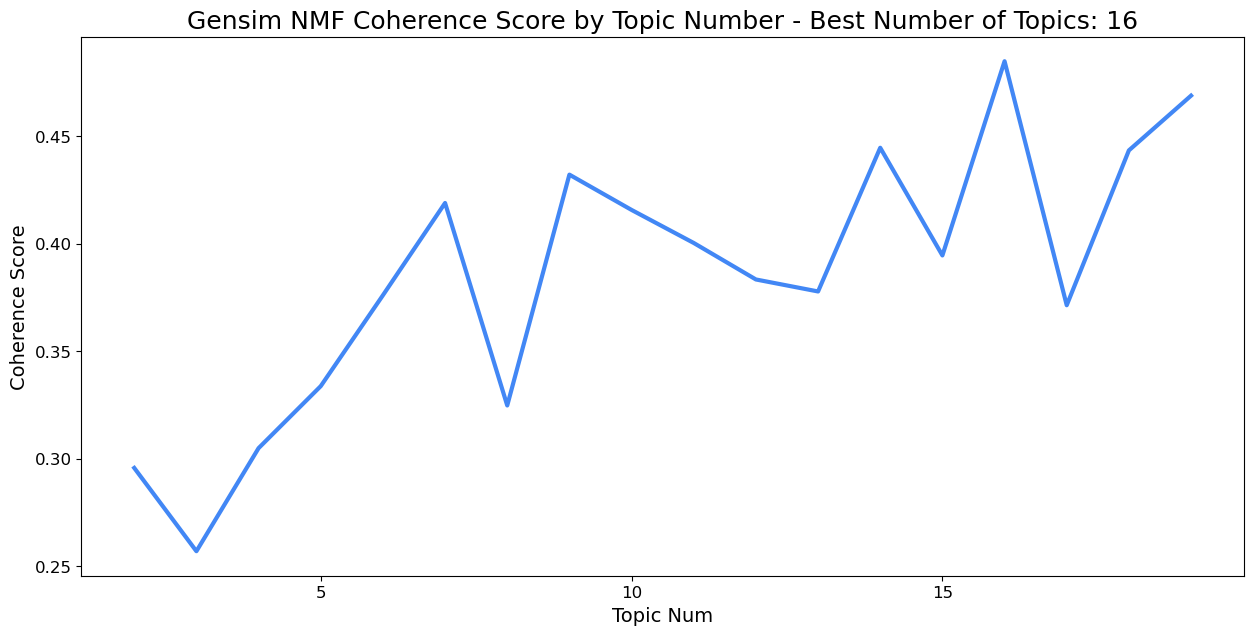

Topic: 0
Words: 0.060*"application" + 0.048*"network" + 0.035*"cloud"
Topic: 1
Words: 0.065*"service" + 0.037*"application" + 0.021*"request"
Topic: 2
Words: 0.079*"container" + 0.048*"image" + 0.047*"docker"
Topic: 3
Words: 0.055*"solution" + 0.031*"datum" + 0.029*"study"
Topic: 4
Words: 0.057*"security" + 0.031*"microservice_architecture" + 0.030*"design"
Topic: 5
Words: 0.077*"security" + 0.041*"policy" + 0.033*"information"
Topic: 6
Words: 0.039*"model" + 0.039*"service" + 0.033*"access_control"
Topic: 7
Words: 0.060*"system" + 0.047*"configuration" + 0.041*"attack"
Topic: 8
Words: 0.040*"system" + 0.031*"service" + 0.029*"provide"
Topic: 9
Words: 0.068*"microservice" + 0.047*"application" + 0.039*"software"
Topic: 10
Words: 0.057*"microservice" + 0.037*"policy" + 0.020*"attack"
Topic: 11
Words: 0.035*"datum" + 0.032*"use" + 0.031*"microservice_base"
Topic: 12
Words: 0.087*"application" + 0.054*"web" + 0.046*"cloud"
Topic: 13
Words: 0.038*"framework" + 0.035*"secure" + 0.034*"edge_

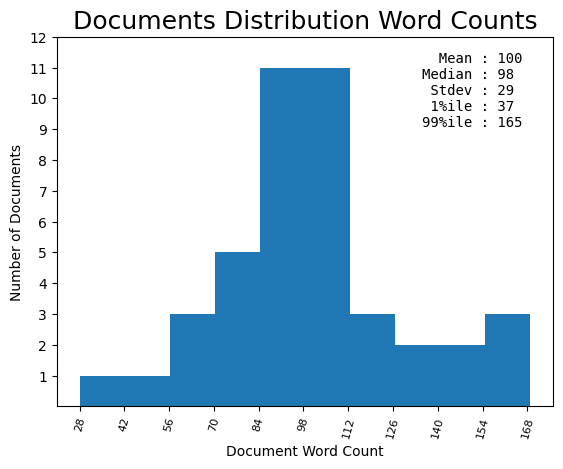

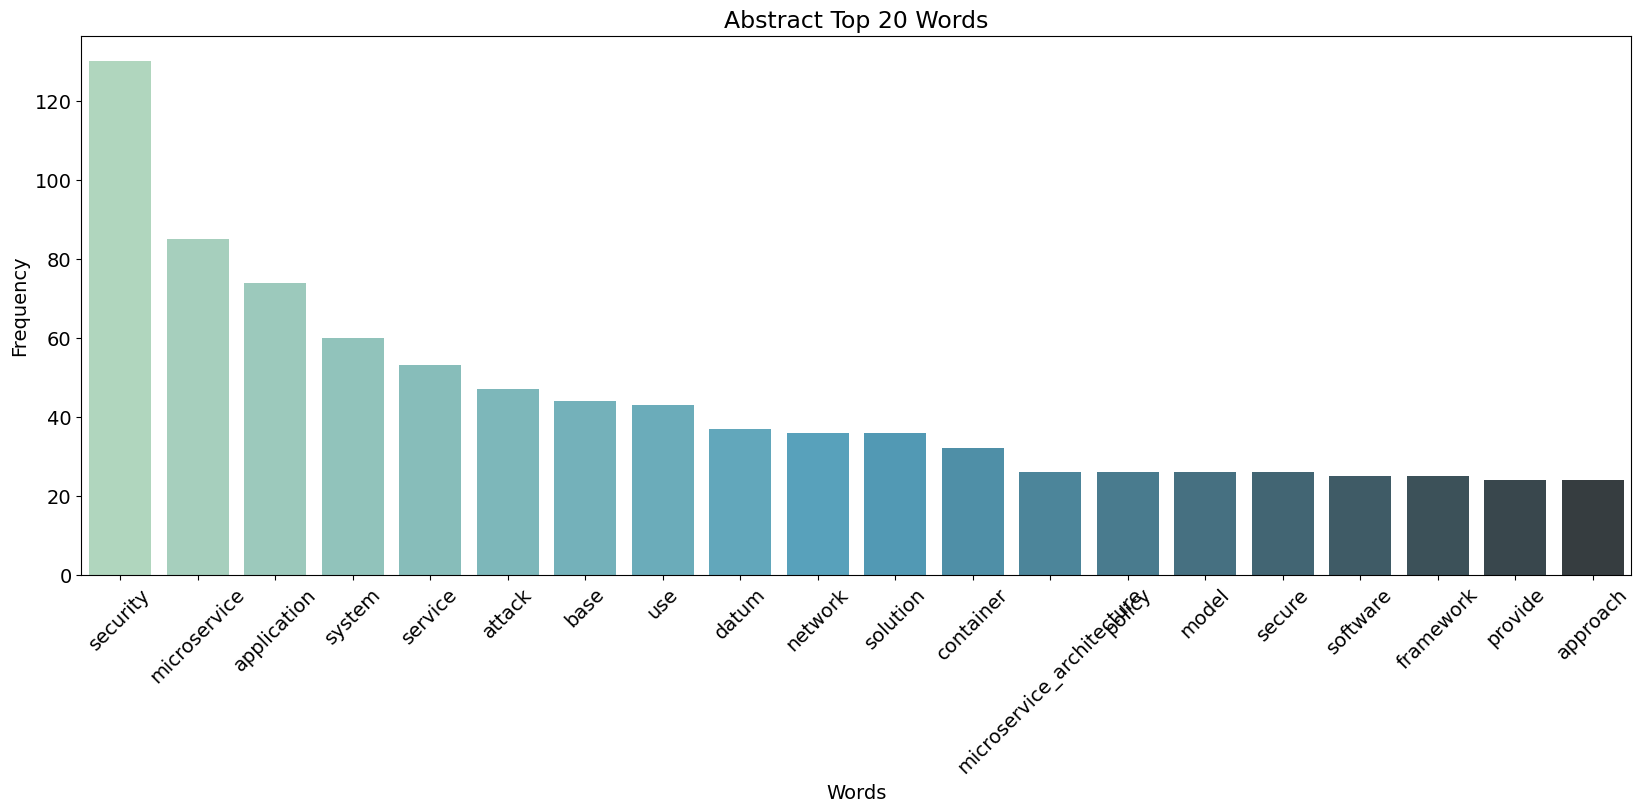

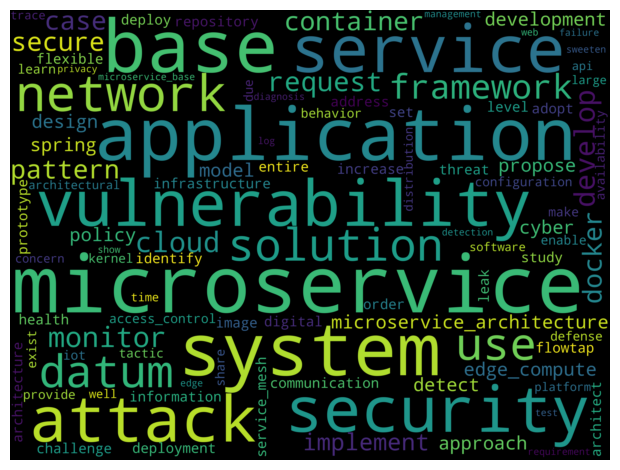

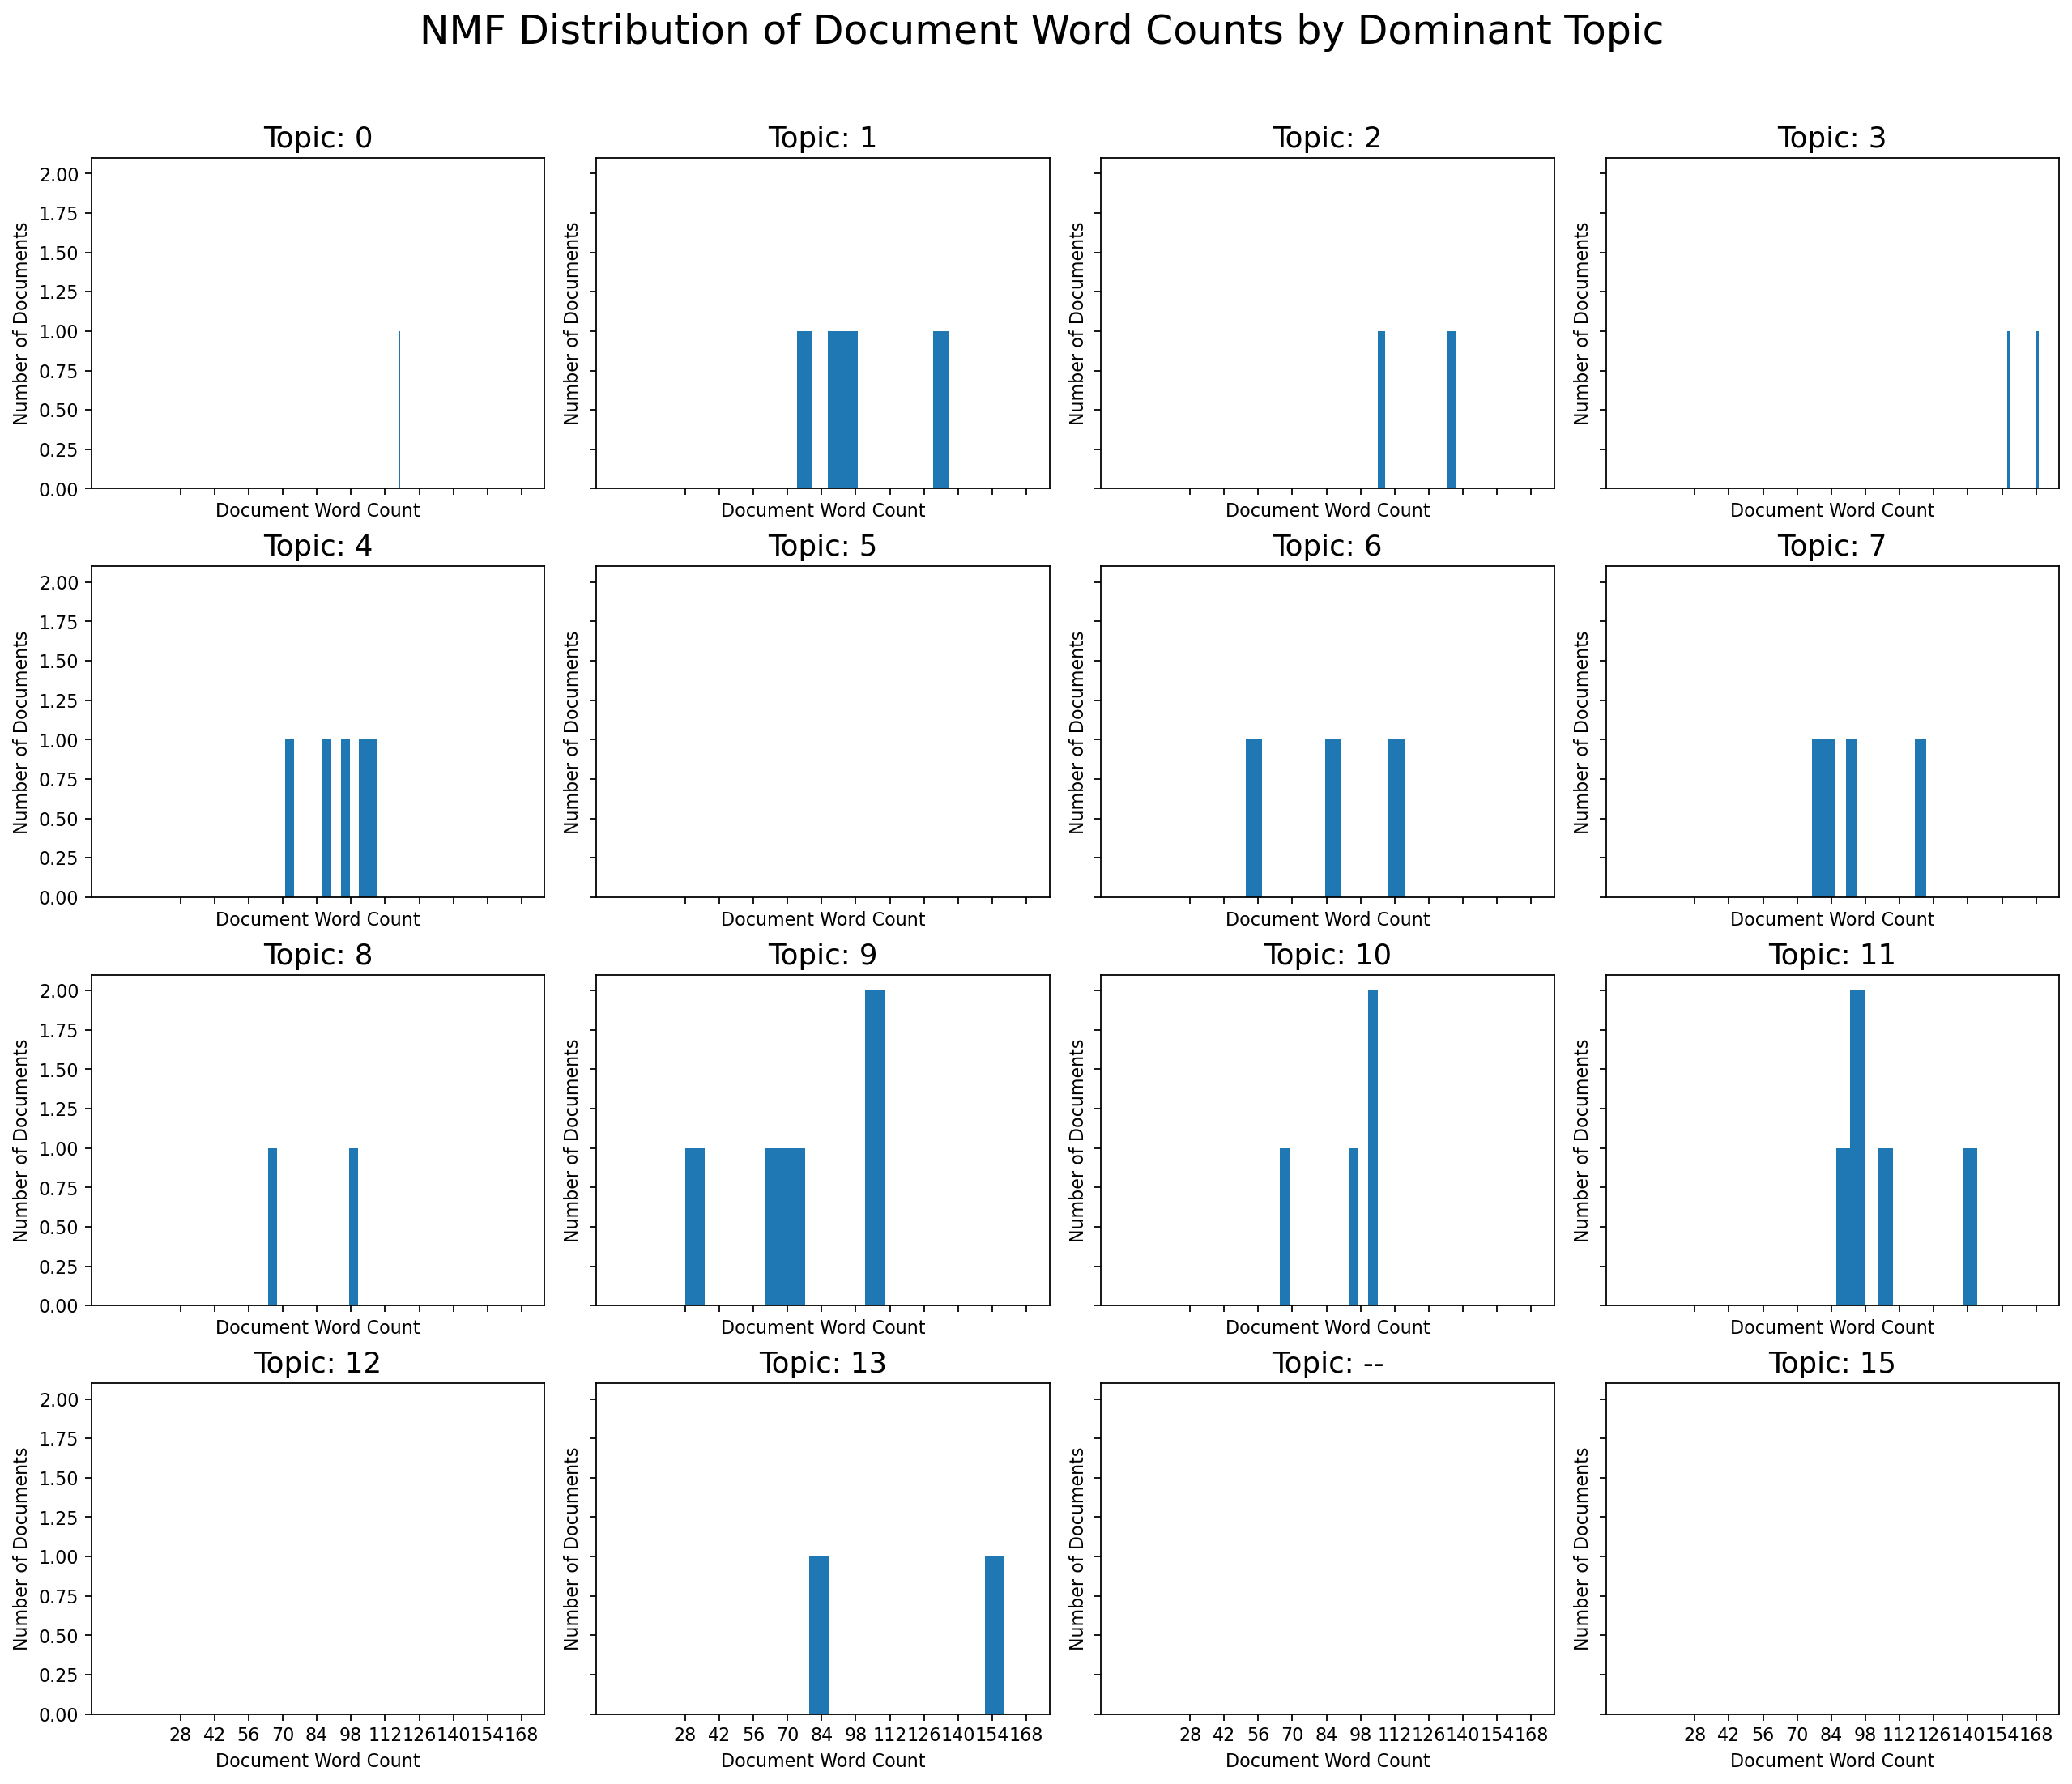

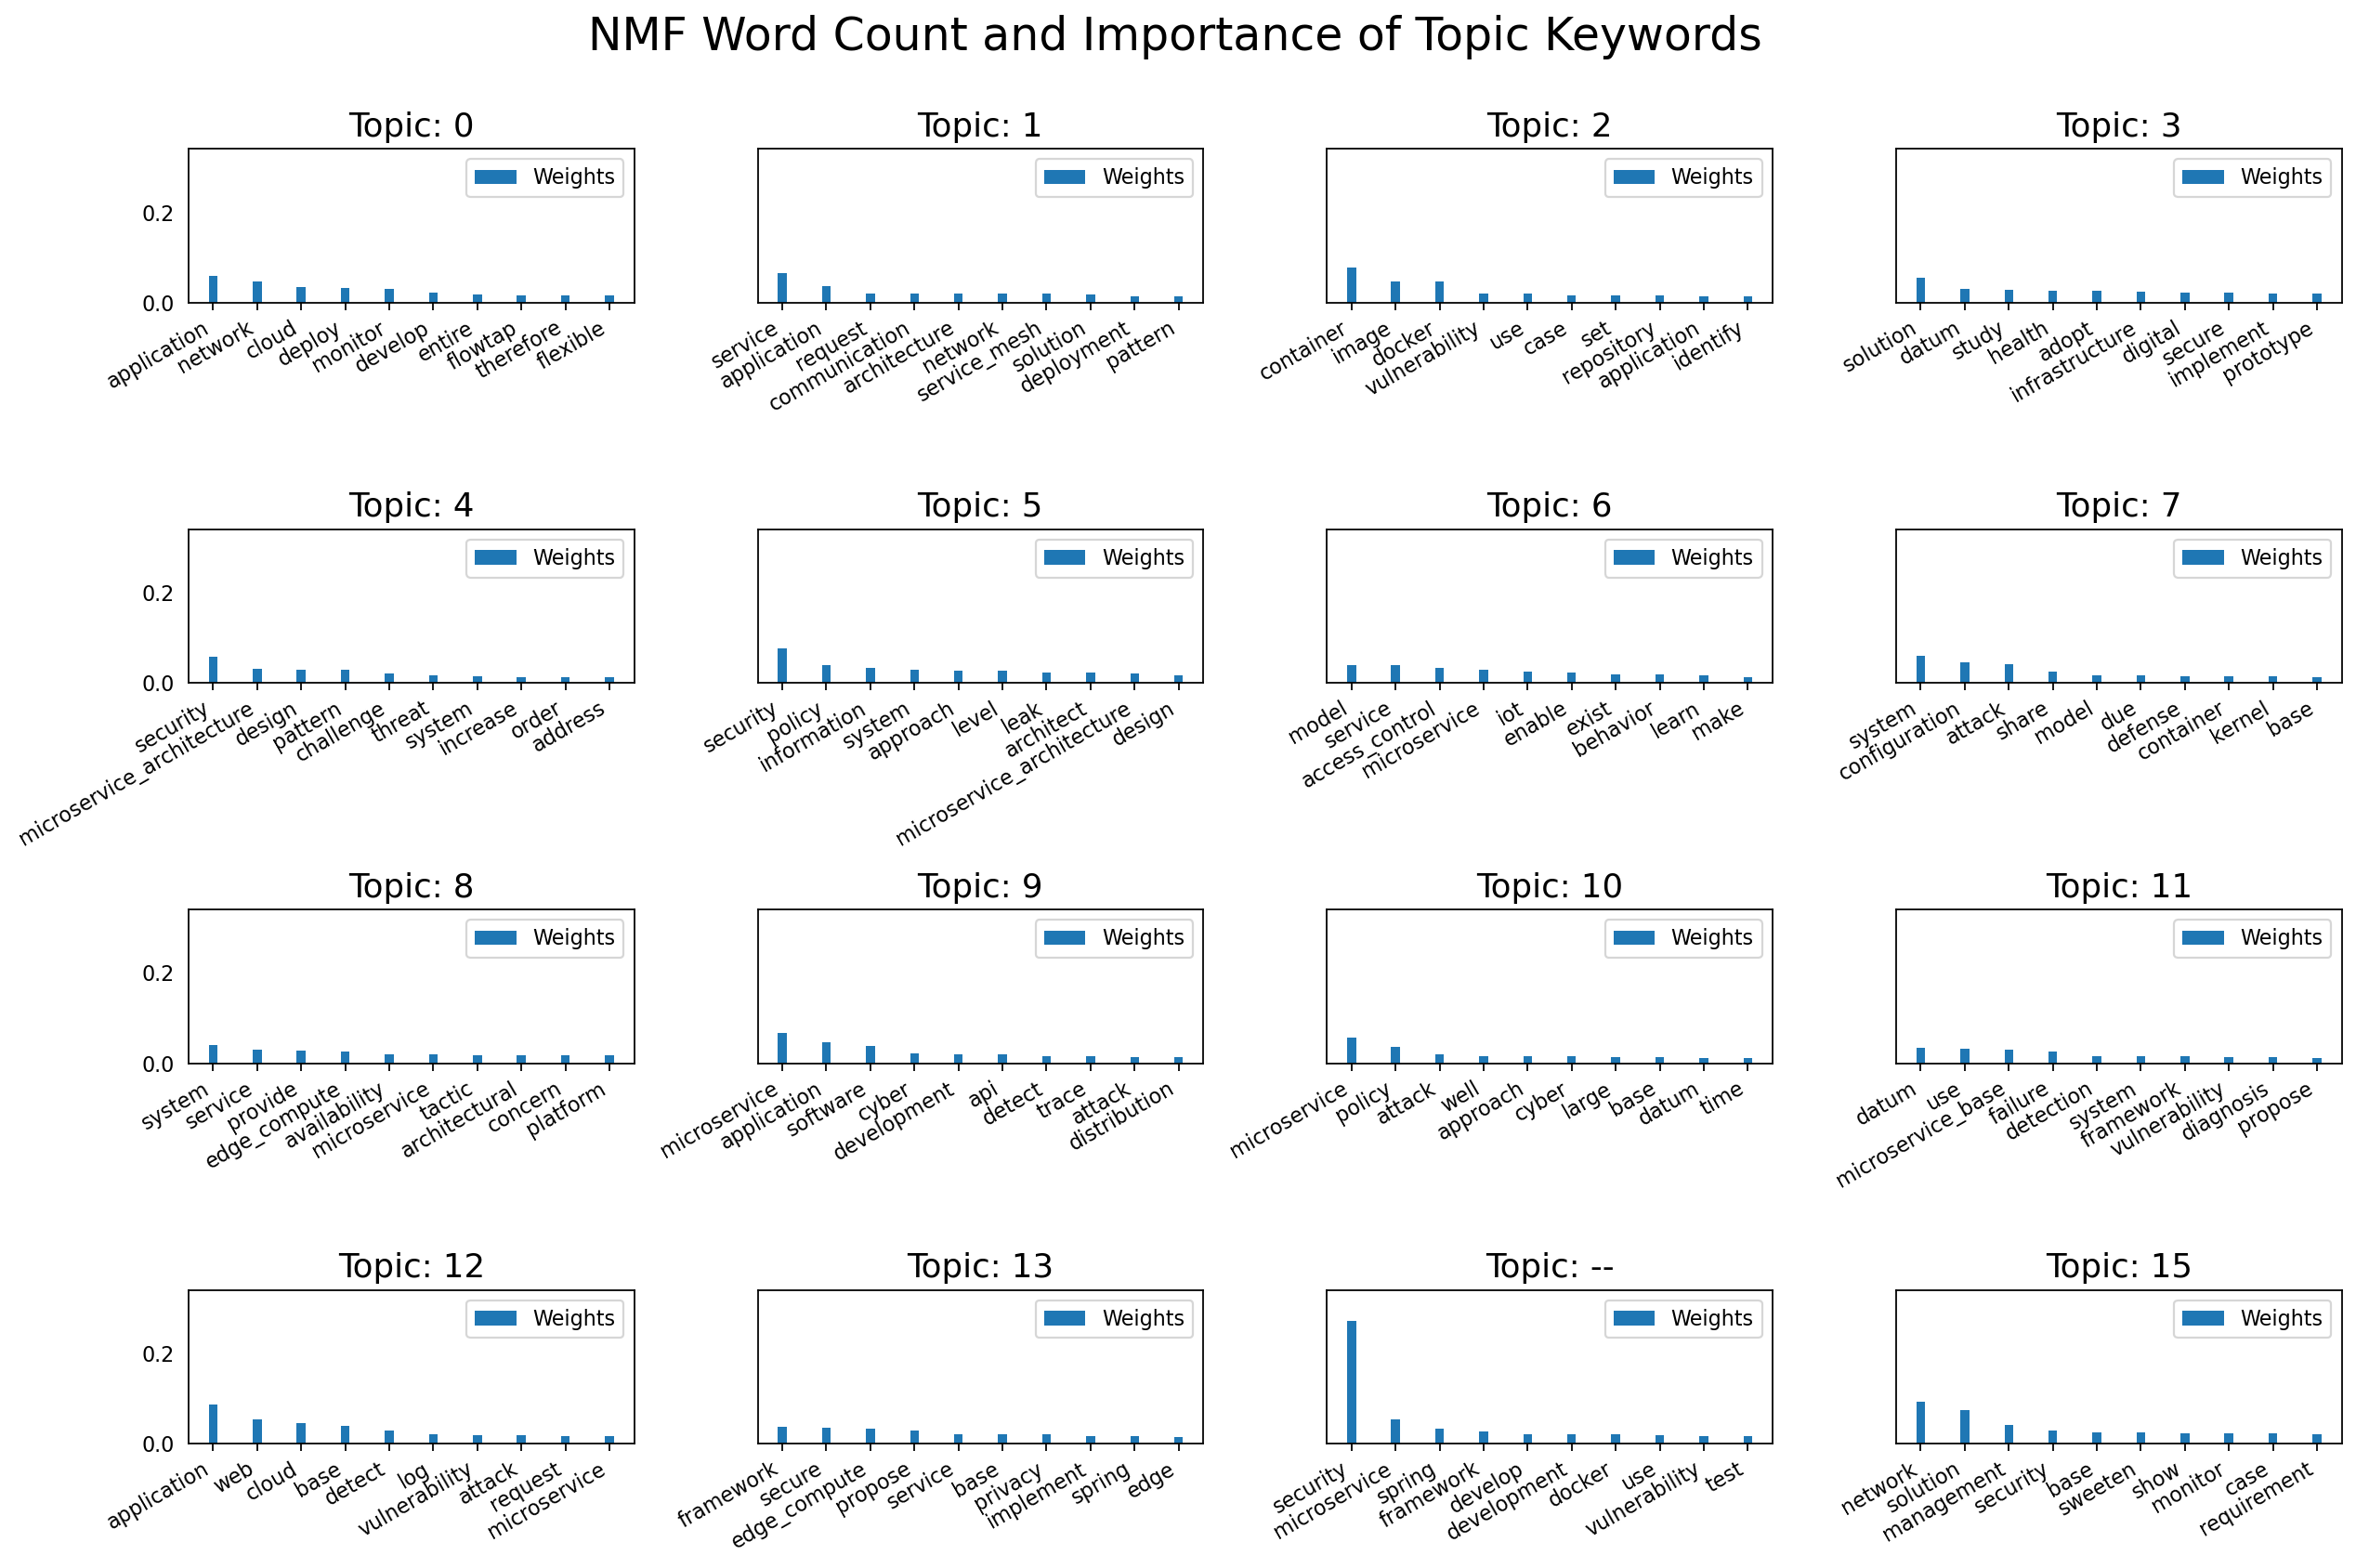

<Figure size 640x480 with 0 Axes>

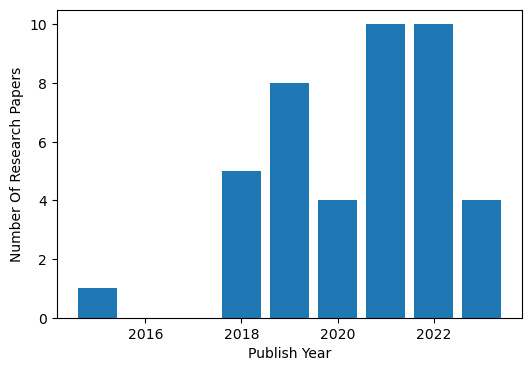

<Figure size 640x480 with 0 Axes>

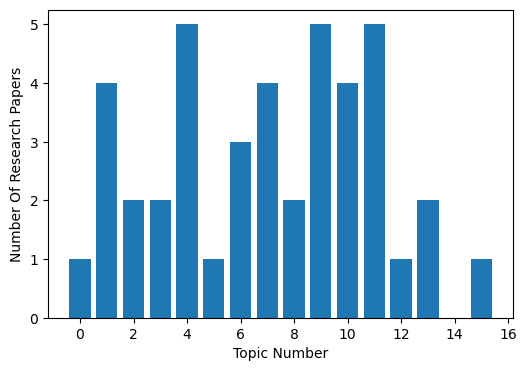

<Figure size 640x480 with 0 Axes>

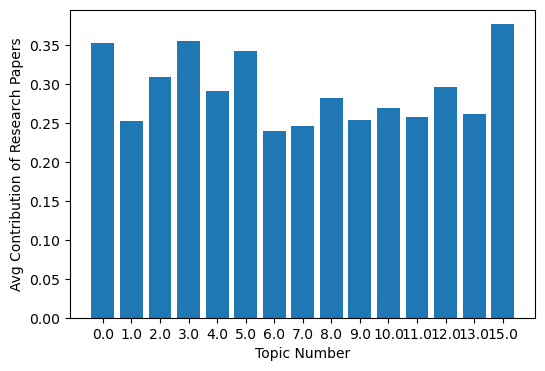

Done
Total Time: 113.99353981018066


In [3]:
import pandas as pd 
import time

if __name__ == "__main__":
    analyze = True
    writeTextFile = False
    delTextFile = False
    numTopics = 20
    abstracts = []
    featureName = 'Abstract'
    
    print('Start data analysis, extracting abstracts from PDFs ...')
    
    #--First, by using MyExtractor, we generated the 'AbstractsDataset.csv'.
    #--Then we are using this CSV for our further analysis
    #extractor = MyExtractor()
    #abstracts, documentsDF = extractor.extractAbstractsUsingPyPDF2(writeTextFile, delTextFile)
    #print('Number of abstracts: ', len(abstracts))
    #documentsDF.to_csv('AbstractsDataset.csv')
    
    # Read the dataset 'AbstractsDataset.csv'
    abstractsDF = pd.read_csv("AbstractsDataset.csv")
    
    # Start NMF Text Analysis
    if analyze:
        start = time.time()
        
        print('Starting NMF analysis ...')
        nmfAnalysis = MyNMF()
        nmfAnalysis.documentTextAnalysis(numTopics, featureName, docsDF = abstractsDF) 
        print('Done')
        
        print('Total Time:', time.time() - start)